# Python code for domain of attraction estimate using a finite-time Lyapunov function (FTLF)

## The method is described in detail in the following paper: 

Pandey, Ayush, and Aaron D. Ames. "On a Converse theorem for Finite-time Lyapunov Functions to Estimate Domains of Attraction." 2020 American Control Conference (ACC). IEEE, 2020.

## Load your model equations as a Python function. In this notebook, we will use the toggle switch dynamics as an example.

### The reduced toggle switch model

In [1]:
import numpy as np
# Toggle switch model
def f(x,*args):
    y = np.zeros(2)
    alpha1, alpha2, beta, gamma = args 
    pt_dot =  alpha1/(1 + x[1]**beta) - x[0]
    pl_dot = alpha2/(1 + x[0]**gamma) - x[1]
    y = np.array([pt_dot, pl_dot])
    return y

### Find all equilibrium points

In [2]:
from scipy.optimize import fsolve
# Parameters
alpha1 = 1.3
alpha2 = 1
beta = 3
gamma = 10

params = tuple([alpha1, alpha2, beta, gamma])
# Find equilibrium points (two stable, one unstable) E_i
n = 2
x0 = [0, 0]
E1 = fsolve(f, x0, args = params)
print('Unstable equilibrium is E1 = {0}'.format(E1))
x0 = [100, 0]
E2 = fsolve(f, x0, args = params)
print('Stable equilibrium #1 is E2 = {0}'.format(E2))
x0 = [0, 100]
E3 = fsolve(f, x0, args = params)
print('Stable equilibrium #2 is E3 = {0}'.format(E3))



Unstable equilibrium is E1 = [0.88066277 0.78088053]
Stable equilibrium #1 is E2 = [1.29959444 0.06782925]
Stable equilibrium #2 is E3 = [0.66679013 0.98292302]


## Shift equilibrium to zero

In [3]:
# Shifted equilibrium to zero dynamics
def fs(x,*args):
    y = np.zeros(2)
    alpha1, alpha2, beta, gamma, E = args 
    pt_dot =  alpha1/(1 + (x[1] + E[1])**beta) - (x[0] + E[0])
    pl_dot = alpha2/(1 + (x[0] + E[0])**gamma) - (x[1] + E[1])
    y = np.array([pt_dot, pl_dot])
    return y

In [4]:
alpha1 = 1.3
alpha2 = 1
beta = 3
gamma = 10

params1 = tuple([alpha1, alpha2, beta, gamma, E1])
params2 = tuple([alpha1, alpha2, beta, gamma, E2])
params3 = tuple([alpha1, alpha2, beta, gamma, E3])
# Find equilibrium points (two stable, one unstable) E_i
n = 2
x0 = [0, 0]
E1s = fsolve(fs, x0, args = params1)
print('Unstable equilibrium is E1 = {0}'.format(E1s))
x0 = [100, 0]
E2s = fsolve(fs, x0, args = params2)
print('Stable equilibrium #1 is E2 = {0}'.format(E2s))

x0 = [0, 100]
E3s = fsolve(fs, x0, args = params3)
print('Stable equilibrium #2 is E3 = {0}'.format(E3s))


Unstable equilibrium is E1 = [-2.18034977e-15  3.01637020e-15]
Stable equilibrium #1 is E2 = [-1.19100641e-13 -4.29527531e-13]
Stable equilibrium #2 is E3 = [ 1.81848814e-14 -2.37463131e-14]


In [5]:
E1s = np.array([0, 0])
E2s = np.array([0, 0])
E3s = np.array([0, 0])
# Linearized dynamics
import numdifftools as nd
from scipy.linalg import norm, solve_continuous_lyapunov, sqrtm, inv, expm
from numpy.linalg import eig
f_ode = lambda xs: fs(xs, *np.array(params1))
Dfx = nd.Jacobian(f_ode)
A1 = Dfx(E1s)
print('The linearization at the unstable equilibrium is {0} with eigen values {1}.'.format(A1, eig(A1)[0]))
f_ode = lambda xs: fs(xs, *np.array(params2))
Dfx = nd.Jacobian(f_ode)
A2 = Dfx(E2s)
print('The linearization at the stable equilibrium #1 is {0} with eigen values {1}.'.format(A2, eig(A2)[0]))
f_ode = lambda xs: fs(xs, *np.array(params3))
Dfx = nd.Jacobian(f_ode)
A3 = Dfx(E3s)
print('The linearization at the stable equilibrium #2 is {0} with eigen values {1}.'.format(A3, eig(A3)[0]))


def weighted_mu(A, P):
    wp = sqrtm(P)@A@inv(sqrtm(P))
    mx = (1/2) * ( wp + wp.T )
    return np.max(eig(mx)[0])

def compute_d(A, P, dcs = np.linspace(5,0.1,100)):
    flag = False
    for dc in dcs:
        wp = sqrtm(P)@expm(dc*A)@inv(sqrtm(P))
        mx = (1/2) * (wp + wp.T)
        if np.max(eig(mx)[0]) < 1:
            d = dc
            flag = True
    if not flag:
        print('No d found, terminating.')
        return
    return d

# For A1
I = np.identity(2)
P1 = solve_continuous_lyapunov(A1.T, -I)
# For A2
P2 = solve_continuous_lyapunov(A2.T, -I)
# For A3
P3 = solve_continuous_lyapunov(A3.T, -I)

# Compute logarithm norm
    
muA1 = weighted_mu(A1, P1)
muA2 = weighted_mu(A2, P2)
muA3 = weighted_mu(A3, P3)
print('The weighted P logarithm norm of A1 is {0}'.format(muA1))
print('The weighted P logarithm norm of A2 is {0}'.format(muA2))
print('The weighted P logarithm norm of A3 is {0}'.format(muA3))
# Iterate over d, to find a d that satisfies linear FTLF condition : norm(e^dA) < 1 (what's the best d?)

    
d2 = compute_d(A2,P2)
d3 = compute_d(A3,P3)
# d2 = 0.4
# d3 = 1.2

The linearization at the unstable equilibrium is [[-1.         -1.09135581]
 [-1.94292451 -1.        ]] with eigen values [ 0.45616687 -2.45616687].
The linearization at the stable equilibrium #1 is [[-1.         -0.01793196]
 [-0.48652444 -1.        ]] with eigen values [-0.90659585 -1.09340415].
The linearization at the stable equilibrium #2 is [[-1.         -0.99127747]
 [-0.25173376 -1.        ]] with eigen values [-0.50046221 -1.49953779].
The weighted P logarithm norm of A1 is (0.39587656574088426+2.2612132167271385e-17j)
The weighted P logarithm norm of A2 is -0.7544222160167673
The weighted P logarithm norm of A3 is -0.4170703298578222


In [7]:
zeta2 = -1 * (np.exp(d2*muA2) - 1)
zeta3 = -1 * (np.exp(d3*muA3) - 1)
DOA_est2 = (d2 * muA2**2) / zeta2
DOA_est3 = (d3 * muA3**2) / zeta3
DOA_lin2 = 0.4# here
DOA_lin3 = 0.15# here

In [8]:
DOA_est2

0.78323764406099

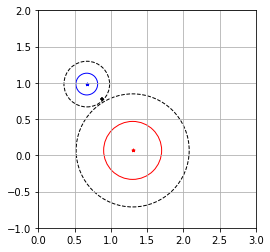

In [9]:
import matplotlib.pyplot as plt
plt.scatter(E1[0], E1[1], s = 10, c = 'k', marker = '+')
plt.scatter(E2[0], E2[1], s = 10, c = 'r', marker = '*')
plt.scatter(E3[0], E3[1], s = 10, c = 'b', marker = '*')
doa_ball2 = plt.Circle(E2, 0.78, color='k', ls = '--', fill = False, clip_on = False)
doa_ball3 = plt.Circle(E3, 0.315, color='k', ls = '--', fill = False, clip_on = False)
doa_lin2 = plt.Circle(E2, DOA_lin2, color='r', fill = False, clip_on = False)
doa_lin3 = plt.Circle(E3,DOA_lin3, color='blue', fill = False, clip_on = False)
# fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim((0, 3))
ax.set_ylim((-1, 2))

ax.add_artist(doa_ball2)
ax.add_artist(doa_ball3)
ax.add_artist(doa_lin2)
ax.add_artist(doa_lin3)
ax.set_aspect('equal')
plt.grid()
plt.savefig('DOA_lin.svg')
plt.show()

In [10]:
from sympy import Symbol
x1 = Symbol('x1')
x2 = Symbol('x2')
t = Symbol('t')

x = np.array([x1,x2])
f2 = np.array([alpha1/(1 + (x[1] + E2[1])**beta) - (x[0] + E2[0]),alpha2/(1 + (x[0] + E2[0])**gamma) - (x[1] + E2[1])])
f2 = np.array([alpha1/(1 + (x[1] + E3[1])**beta) - (x[0] + E3[0]),alpha2/(1 + (x[0] + E3[0])**gamma) - (x[1] + E3[1])])
int_fun2 = (x + t*f2).T@P2@(x+t*f2)
int_fun3 = (x + t*f3).T@P3@(x+t*f3)
Wx2 = quad(int_fun2, t, 0, d2);
Wx3 = quad(int_fun3, t, 0, d3);
gradWx21 = diff(Wx2, x1);
gradWx22 = diff(Wx2, x2);
gradWx31 = diff(Wx3, x1);
gradWx32 = diff(Wx3, x2);
gradWx2 = np.array([gradWx21, gradWx22])
gradWx3 = np.array([gradWx31, gradWx32])
Wdot2 = gradWx2.T@f2
Wdot3 = gradWx3.T@f3

TypeError: ufunc 'matmul' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
def find_DOA(eq_pt, P, d, params, unit, x_max, x_min, Cs, tol = 0.1):
    dim = np.shape(eq_pt)[0]
    assert unit > 0
    assert np.shape(x_max)[0] == dim
    assert np.shape(x_min)[0] == dim
    x1_max = x_max[0]
    x1_min = x_min[0]

    x2_max = x_max[1]
    x2_min = x_min[1]


    start = eq_pt
    x1_start = start[0]
    x2_start = start[1]


#     answer = np.zeros((abs(x1_max)+abs(x1_min),abs(x2_max) + abs(x2_min)))

    #wdot(x, *args) is the function where x is the vector (x1, x2)
    #unit is the step size


#     answer[x1_start][x2_start] = 1
    answer = {}
    for C in Cs:
        answer[C] = []
        answer[C].append((x1_start, x2_start))
        visited = [(x1_start, x2_start)]
        while(len(visited) > 0 ):
            (x1, x2) = visited.pop()
            if x1 - unit >= x1_min  and Wdot.subs((np.array([x1 - unit, x2])) <= 0 and W.subs(np.array([x1 - unit, x2]) -C <= 0:
                if not (x1 - unit, x2) in answer[C]:
                    visited.append((x1-unit, x2))
                    answer[C].append((x1 - unit,x2))
            if x1 + unit >= x1_min  and Wdot.subs((np.array([x1 + unit, x2])) <= 0 and W.subs(np.array([x1 + unit, x2]) -C <= 0:
                if not (x1 + unit, x2) in answer[C]:
                    visited.append((x1+unit, x2))
                    answer[C].append((x1 + unit,x2))
            if x2 - unit >= x1_min  and Wdot.subs((np.array([x2 - unit, x2])) <= 0 and W.subs(np.array([x2 - unit, x2]) -C <= 0:
                if not (x1, x2 - unit) in answer[C]:
                    visited.append((x1, x2 - unit))
                    answer[C].append((x1,x2 - unit))
            if x2 + unit >= x1_min  and Wdot.subs((np.array([x2 + unit, x2])) <= 0 and W.subs(np.array([x2 + unit, x2]) -C <= 0:
                if not (x1, x2+unit) in answer[C]:
                    visited.append((x1, x2 + unit))
                    answer[C].append((x1,x2 + unit))
    return answer



In [ ]:

x_max = [50,50]
x_min = [-5,-5]
answer = find_DOA(E2, P2, d2, params2, 0.1, x_max, x_min, np.linspace(0.1,0.15,5), tol = 1)
answer = plot_DOA(E2, P2, 2, params2, 0.01, x_max, x_min, np.linspace(0.01,1.5,10000), tol = 0.1, plot_show = True)


In [11]:
P2

array([[ 0.56189761, -0.12722404],
       [-0.12722404,  0.50228138]])

In [12]:
from scipy.linalg import norm
def Sd(x,E,r):
#     % This function checks whether the given point (vector) x is inside a
#     % ball of radius r with center at E. If inside, res will be negative. 
    res = norm(x - E, 2) - r;
    return res

In [15]:
from sympy import Symbol, Matrix
from sympy import integrate
C2 = 0.2
C3 = 1.7

x1s = np.linspace(-2,5,100)
x2s = np.linspace(-2,5,100)

pointsx = []
pointsy = []
pointsx3 = []
pointsy3 = []

# % Symbolically write down the toggle switch model so that we can perform
# % integration to compute Wx as given by the formula in the paper equation
# % (30)
x1 = Symbol('x1')
x2 = Symbol('x2')
t = Symbol('t')
x = [x1, x2]

f2 = np.array([alpha1/(1 + (x[1] + E2[1])**beta) - (x[0] + E2[0]), alpha2/(1 + (x[0] + E2[0])**gamma) - (x[1] + E2[1])])
f3 = np.array([alpha1/(1 + (x[1] + E3[1])**beta) - (x[0] + E3[0]), alpha2/(1 + (x[0] + E3[0])**gamma) - (x[1] + E3[1])])

# % The function to integrate (see equation 30)
int_fun2 = (Matrix(x + t*f2).T @ Matrix(P2)) @ Matrix(x+t*f2)

int_fun3 = (Matrix(x + t*f3).T@Matrix(P3))@ Matrix(x+t*f3)


Wx2 = integrate(int_fun2, (t, 0, d2) )
Wx3 = integrate(int_fun3, (t, 0, d3) )
def gradient(scalar_function, variables):
    matrix_scalar_function = Matrix([scalar_function])
    return matrix_scalar_function.jacobian(variables)


gradWx2 = gradient(Wx2, x);
gradWx3 = gradient(Wx3, x);


In [16]:

d2 = 0.1
d3 = 0.8

# %% Compute radius of ball in d-invariant set
# % Check Definition 4 in the paper 
zeta2 = -1 * (np.exp(d2*muA2) - 1)
zeta3 = -1 * (np.exp(d3*muA3) - 1)
dinv2 = (d2 * muA2**2) / zeta2
dinv3 = (d3 * muA3**2) / zeta3
r2 = dinv2 +0.05
r3 = dinv3-0.2

In [17]:
np.shape(Matrix(f2))

(2, 1)

In [18]:

Wdot2 = gradWx2.T @ Matrix(f2).T
Wdot3 = gradWx3.T @ Matrix(f3).T


# %% Search algorithm to find DOAs:
for i in range(len(x1s)):
    x1v = x1s[i]
    for j in range(len(x2s)):
        x2v = x2s[j]
        
        Wx2s = Wx2.subs(x1, x1v)
        Wx2ss = Wx2s.subs(x2, x2v)
        
        Wdot2s = Wdot2.subs(x1, x1v)
        Wdot2ss = Wdot2s.subs(x2, x2v)
        
        Wx3s = Wx3.subs(x1, x1v)
        Wx3ss = Wx3s.subs(x2, x2v)
        
        Wdot3s = Wdot3.subs(x1, x1v)
        Wdot3ss = Wdot3s.subs(x2, x2v)
        
        if float(Wx2ss[0]) - C2 <= 0 and float(Wdot2ss[0]) <= 0:
            if Sd([x1v,x2v], E2, r2) <= 0:
                pointsx = [pointsx, x1v]
                pointsy = [pointsy, x2v]
        if float(Wx3ss[0]) - C3 <= 0 and float(Wdot3ss[0]) <= 0:
            if Sd([x1v,x2v], E3, r3) <= 0:
                pointsx3 = [pointsx3, x1v]
                pointsy3 = [pointsy3, x2v]
pointsx = pointsx.T
pointsy = pointsy.T
pointsx3 = pointsx3.T
pointsy3 = pointsy3.T

# k = boundary(pointsx,pointsy);
# k3 = boundary(pointsx3,pointsy3);

plt.plot(pointsx[k],pointsy[k],'b')
plt.plot(pointsx3[k3],pointsy3[k3],'r')
# % plot the d-invariant sets (uncomment, if needed)
# % plot_circle(E2(1),E2(2),r2)
# % plot_circle(E3(1),E3(2),r3)
# % scatter(pointsx, pointsy)
# plot(E1(1),E1(2),'kx')
# plot(E2(1), E2(2), 'bo')
# plot(E3(1), E3(2), 'ro')



AttributeError: 'list' object has no attribute 'T'

In [ ]:
r3

In [ ]:
norm